In [97]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from snapfish2.impute.simulate import TraceSample
from snapfish2.impute.spatial import *

In [2]:
%reload_ext autoreload
%autoreload 2

[Text(0.5, 1.0, 'Part of Hi-C contact map at 5kb resolution')]

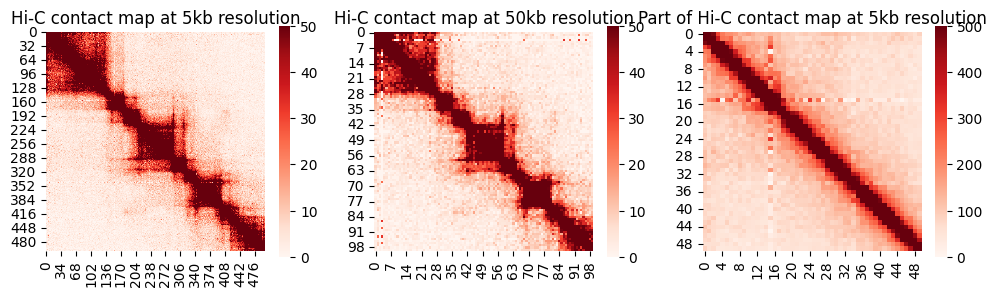

In [152]:
n = 500 # number of loci
hic_txt = np.genfromtxt("data/bonev_2017/4DNFI4OUMWZ8.KR.10Kb.chr1.txt", max_rows=int(n*(n+1)/2))

type_dict = {"bin1":"int64", "bin2":"int64", "count":"float64"}
hic_df = pd.DataFrame(hic_txt, columns=type_dict.keys())
hic_df = hic_df.astype(type_dict)

# missing entries, more rows than needed
last_bin = pd.unique(hic_df.bin1)[n-1]
hic_df = hic_df[(hic_df.bin1 <= last_bin)&(hic_df.bin2 <= last_bin)]

hic_wide = hic_df.pivot(columns="bin1", index="bin2", values="count")
contact_map = hic_wide.values
tril_idx = np.tril_indices_from(contact_map)
contact_map.T[tril_idx] = contact_map[tril_idx]
# still has missing values
contact_map[np.isnan(contact_map)] = 0

# scale down the resolution by a factor of 10
low_resol_map = contact_map[::5, ::5]

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.heatmap(contact_map, vmax=50, cmap="Reds", square=True, ax=axes[0])
axes[0].set(title="Hi-C contact map at 5kb resolution")

sns.heatmap(low_resol_map, vmax=50, cmap="Reds", square=True, ax=axes[1])
axes[1].set(title="Hi-C contact map at 50kb resolution")

sns.heatmap(contact_map[:50, :50], vmax=500, cmap="Reds", square=True, ax=axes[2])
axes[2].set(title="Part of Hi-C contact map at 5kb resolution")

In [121]:
# check positive semidefiniteness
np.sum(np.linalg.eigvals(low_resol_map) < 0)

0

In [123]:
N, R = int(1e4), low_resol_map.shape[0]
shifts = np.random.uniform(0, 1e3, (3, N))
shifts = np.zeros((3, N))
ts = TraceSample(N=N, R=R, K=low_resol_map, tau=[0, 5, 100], obs_p=1, shifts=shifts)
ts.samples.shape

(3, 10000, 100)

In [157]:
N = int(1e5)
low_var_map = low_resol_map.copy()
low_var_map[np.diag_indices_from(low_var_map)] = np.diag(low_var_map)
L = np.linalg.cholesky(low_var_map)
norm_samples = stats.norm.rvs(0, 1, (N, R))
samples = (L@norm_samples.T).T

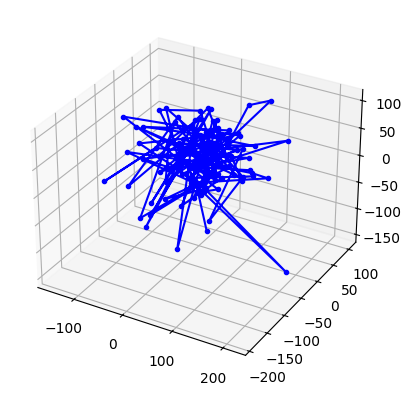

In [158]:
ax1 = plt.subplot(projection="3d")
ax1.plot(*samples[:3], ".-", color="b")
# ax1.plot(trace_df.X, trace_df.Y, trace_df.Z, ".", color=pal[1])

<Axes: >

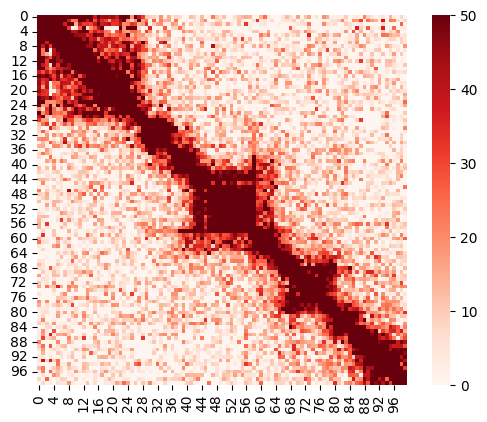

In [144]:
# sns.heatmap(sample_covar_loh(ts.samples[0]), vmin=0, vmax=50, cmap="Reds", square=True)
a = sample_covar_loh(samples)
b = sample_covar_heteroPCA(a, 10)
sns.heatmap(a, vmin=0, vmax=50, cmap="Reds", square=True)